<a href="https://colab.research.google.com/github/pooja251096/Rossmann-Sales-Prediction-/blob/main/Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [2]:
# Importing the libraries
import numpy as np
import pandas as pd
from numpy import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import neighbors
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import datetime

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
store_data = pd.read_csv('/content/drive/MyDrive/Almabetter learning/Retail sales prediction/Rossmann Stores Data.csv')
stores = pd.read_csv('/content/drive/MyDrive/Almabetter learning/Retail sales prediction/store.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
store_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
## Convert date column from object to date
store_data['Date']= pd.to_datetime(store_data['Date'])

In [7]:
store_data['Year'] = pd.DatetimeIndex(store_data['Date']).year
store_data['Month'] = pd.DatetimeIndex(store_data['Date']).month

In [8]:
store_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7


In [9]:
stores.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [10]:
## Wherever Promo2 ie continuing and consecutive promotion is zero, implies store didn't participate,
# hence Promo2SinceWeek and Promo2SinceYear should be zero, also there won't be PromoInterval
stores.loc[(stores['Promo2']==0) & (stores['Promo2SinceWeek'].isna()),['Promo2SinceWeek']]=0
stores.loc[(stores['Promo2']==0) & (stores['Promo2SinceYear'].isna()),['Promo2SinceYear','PromoInterval']]=0

In [11]:
stores.loc[stores['CompetitionDistance'].isna()]=stores['CompetitionDistance'].max()#CompetitionDistance

In [12]:
stores.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth    351
CompetitionOpenSinceYear     351
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear                0
PromoInterval                  0
dtype: int64

In [13]:
## CompetitionOpenSinceMonth and CompetitionOpenSinceYear have been combined, 
## so no changes in individual columns, 
## in the final data set both have been dropped

In [14]:
store_data['Date'].min()

Timestamp('2013-01-01 00:00:00')

In [15]:
stores[stores['Promo2SinceYear']!=0]['Promo2SinceYear'].min()

2009.0

In [16]:
### Code Ref https://www.kaggle.com/shivam017arora/rossmann-sales-prediction-top-1-solution
## Modified accordingly

competition_open = []
for index, value in stores[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']].iterrows():
    try:
        year, month = int(value['CompetitionOpenSinceYear']), int(value['CompetitionOpenSinceMonth'])
        date = pd.to_datetime("{}-{}-01".format(year, month), format='%Y-%m')
        competition_open.append(date)
    except:
        competition_open.append('1813-01-01') # Added a dummy date, 200 yrs less than min sales date
stores['CompetitionOpen'] = pd.Series(competition_open)
stores['CompetitionOpen'] = stores['CompetitionOpen'].dt.strftime('%Y-%m-%d')
stores['CompetitionOpen']= pd.to_datetime(stores['CompetitionOpen'])





promo = []
for index, value in stores[['Promo2SinceWeek', 'Promo2SinceYear']].iterrows():
    try:
        year, week = int(value['Promo2SinceYear']), int(value['Promo2SinceWeek'])
        date = pd.to_datetime("{}{}0".format(year, week), format='%Y%W%w')
        promo.append(date)
    except:
        promo.append('1909-01-01')   ## dummy date
stores['promoYearWeek'] = pd.to_datetime(pd.Series(promo))
stores['promoYearWeek'] = stores['promoYearWeek'].dt.strftime('%Y%m%d')
stores['promoYearWeek']= pd.to_datetime(stores['promoYearWeek'])


In [17]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store                      1115 non-null   int64         
 1   StoreType                  1115 non-null   object        
 2   Assortment                 1115 non-null   object        
 3   CompetitionDistance        1115 non-null   float64       
 4   CompetitionOpenSinceMonth  764 non-null    float64       
 5   CompetitionOpenSinceYear   764 non-null    float64       
 6   Promo2                     1115 non-null   int64         
 7   Promo2SinceWeek            1115 non-null   float64       
 8   Promo2SinceYear            1115 non-null   float64       
 9   PromoInterval              1115 non-null   object        
 10  CompetitionOpen            1115 non-null   datetime64[ns]
 11  promoYearWeek              1115 non-null   datetime64[ns]
dtypes: dat

In [18]:
stores.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpen,promoYearWeek
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2008-09-01,1909-01-01
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2007-11-01,2010-04-04
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2006-12-01,2011-04-10
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,2009-09-01,1909-01-01
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,2015-04-01,1909-01-01


In [19]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 11 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
 9   Year           1017209 non-null  int64         
 10  Month          1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 85.4+ MB


In [20]:
store_data_merged=pd.merge(store_data,stores,on='Store')

In [21]:
store_data_merged['day_diff_comp']=(store_data_merged['Date']-store_data_merged['CompetitionOpen']).dt.days
store_data_merged['day_diff_promo']=(store_data_merged['Date']-store_data_merged['promoYearWeek']).dt.days
store_data_merged.loc[store_data_merged['day_diff_comp']>=73000,'day_diff_comp']=0
store_data_merged.loc[store_data_merged['day_diff_promo']>=36500,'day_diff_promo']=0

In [22]:
store_data_merged.drop(columns=['CompetitionOpenSinceYear','CompetitionOpenSinceMonth','Promo2SinceWeek','Promo2SinceYear','PromoInterval','CompetitionOpen','promoYearWeek'],inplace=True)

In [23]:
#store_data.drop(columns='Date',inplace=True)
store_data_merged.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,StoreType,Assortment,CompetitionDistance,Promo2,day_diff_comp,day_diff_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,c,a,1270.0,0,2524,0
1,1,4,2015-07-30,5020,546,1,1,0,1,2015,7,c,a,1270.0,0,2523,0
2,1,3,2015-07-29,4782,523,1,1,0,1,2015,7,c,a,1270.0,0,2522,0
3,1,2,2015-07-28,5011,560,1,1,0,1,2015,7,c,a,1270.0,0,2521,0
4,1,1,2015-07-27,6102,612,1,1,0,1,2015,7,c,a,1270.0,0,2520,0


In [24]:
store_data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1014567 entries, 0 to 1014566
Data columns (total 17 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Store                1014567 non-null  int64         
 1   DayOfWeek            1014567 non-null  int64         
 2   Date                 1014567 non-null  datetime64[ns]
 3   Sales                1014567 non-null  int64         
 4   Customers            1014567 non-null  int64         
 5   Open                 1014567 non-null  int64         
 6   Promo                1014567 non-null  int64         
 7   StateHoliday         1014567 non-null  object        
 8   SchoolHoliday        1014567 non-null  int64         
 9   Year                 1014567 non-null  int64         
 10  Month                1014567 non-null  int64         
 11  StoreType            1014567 non-null  object        
 12  Assortment           1014567 non-null  object        
 1

In [25]:
store_data_merged['CompetitionDistance']=store_data_merged['CompetitionDistance'].astype(int)

In [26]:
store_data_merged['Assortment']=store_data_merged['Assortment'].apply(lambda x: 1 if x=='a' else (2 if x=='b' else 3))

In [27]:
store_data_final=pd.get_dummies(store_data_merged,drop_first=True)

In [28]:
store_data_final.isna().sum()


Store                  0
DayOfWeek              0
Date                   0
Sales                  0
Customers              0
Open                   0
Promo                  0
SchoolHoliday          0
Year                   0
Month                  0
Assortment             0
CompetitionDistance    0
Promo2                 0
day_diff_comp          0
day_diff_promo         0
StateHoliday_0         0
StateHoliday_a         0
StateHoliday_b         0
StateHoliday_c         0
StoreType_b            0
StoreType_c            0
StoreType_d            0
dtype: int64

In [29]:
store_data_final.drop(columns=['Date'],inplace=True) ## Dropping Date column as month and year have been extracted

In [30]:
############ Final Data

In [31]:
store_data_final

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Year,Month,Assortment,CompetitionDistance,Promo2,day_diff_comp,day_diff_promo,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_b,StoreType_c,StoreType_d
0,1,5,5263,555,1,1,1,2015,7,1,1270,0,2524,0,1,0,0,0,0,1,0
1,1,4,5020,546,1,1,1,2015,7,1,1270,0,2523,0,1,0,0,0,0,1,0
2,1,3,4782,523,1,1,1,2015,7,1,1270,0,2522,0,1,0,0,0,0,1,0
3,1,2,5011,560,1,1,1,2015,7,1,1270,0,2521,0,1,0,0,0,0,1,0
4,1,1,6102,612,1,1,1,2015,7,1,1270,0,2520,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014562,1115,6,4771,339,1,0,1,2013,1,3,5350,1,0,216,1,0,0,0,0,0,1
1014563,1115,5,4540,326,1,0,1,2013,1,3,5350,1,0,215,1,0,0,0,0,0,1
1014564,1115,4,4297,300,1,0,1,2013,1,3,5350,1,0,214,1,0,0,0,0,0,1
1014565,1115,3,3697,305,1,0,1,2013,1,3,5350,1,0,213,1,0,0,0,0,0,1


In [32]:
np.all(np.isfinite(store_data_final))

True

In [33]:
np.any(np.isnan(store_data_final))

False

In [34]:
store_data_final.to_csv('sample.csv')
#from google.colab import files
#files.download("sample4.csv")

In [35]:
dataset = pd.read_csv('sample.csv')


In [36]:
dataset.columns

Index(['Unnamed: 0', 'Store', 'DayOfWeek', 'Sales', 'Customers', 'Open',
       'Promo', 'SchoolHoliday', 'Year', 'Month', 'Assortment',
       'CompetitionDistance', 'Promo2', 'day_diff_comp', 'day_diff_promo',
       'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
       'StoreType_b', 'StoreType_c', 'StoreType_d'],
      dtype='object')

In [37]:
dataset = dataset[['Store', 'DayOfWeek', 'Customers', 'Open',
       'Promo', 'SchoolHoliday', 'Year', 'Month', 'Assortment',
       'CompetitionDistance', 'Promo2', 'day_diff_comp', 'day_diff_promo',
       'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
       'StoreType_b', 'StoreType_c', 'StoreType_d', 'Sales']]

In [38]:
dataset.fillna(0)

,Store,DayOfWeek,Customers,Open,Promo,SchoolHoliday,Year,Month,Assortment,CompetitionDistance,Promo2,day_diff_comp,day_diff_promo,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_b,StoreType_c,StoreType_d,Sales
0,1,5,555,1,1,1,2015,7,1,1270,0,2524,0,1,0,0,0,0,1,0,5263
1,1,4,546,1,1,1,2015,7,1,1270,0,2523,0,1,0,0,0,0,1,0,5020
2,1,3,523,1,1,1,2015,7,1,1270,0,2522,0,1,0,0,0,0,1,0,4782
3,1,2,560,1,1,1,2015,7,1,1270,0,2521,0,1,0,0,0,0,1,0,5011
4,1,1,612,1,1,1,2015,7,1,1270,0,2520,0,1,0,0,0,0,1,0,6102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014562,1115,6,339,1,0,1,2013,1,3,5350,1,0,216,1,0,0,0,0,0,1,4771
1014563,1115,5,326,1,0,1,2013,1,3,5350,1,0,215,1,0,0,0,0,0,1,4540
1014564,1115,4,300,1,0,1,2013,1,3,5350,1,0,214,1,0,0,0,0,0,1,4297
1014565,1115,3,305,1,0,1,2013,1,3,5350,1,0,213,1,0,0,0,0,0,1,3697


In [39]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [40]:
#Splitting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42 )

In [41]:
print(X_train)

[[ 574    4  565 ...    0    0    1]
 [1084    3  690 ...    0    0    0]
 [ 239    1  267 ...    0    0    1]
 ...
 [ 146    3  578 ...    0    0    1]
 [ 740    4  527 ...    0    0    1]
 [ 134    6  287 ...    0    0    0]]


In [42]:
print(y_train)

[6935 4849 2935 ... 5349 7441 2963]


In [43]:
print(X_test)

[[ 851    6  494 ...    0    0    1]
 [ 412    2  454 ...    0    0    1]
 [ 281    1  410 ...    0    0    1]
 ...
 [ 821    3  909 ...    0    0    0]
 [ 363    5  884 ...    0    0    0]
 [1020    3 1108 ...    0    0    0]]


In [44]:
print(y_test)

[5337 5451 3968 ... 7876 6887 9505]


In [45]:
#Preprocessing – Scaling the features

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(X_train)
x_train = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(X_test)
x_test = pd.DataFrame(x_test_scaled)

** Let us have a look at the error rate for different k values**

In [47]:
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=-1)
    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 722.3204128024856
RMSE value for k=  2 is: 638.8299059562694
RMSE value for k=  3 is: 610.0893266708924
RMSE value for k=  4 is: 600.5323106043336
RMSE value for k=  5 is: 596.1574180252185
RMSE value for k=  6 is: 595.9854484569124
RMSE value for k=  7 is: 596.7304269362072
RMSE value for k=  8 is: 598.7650556897136
RMSE value for k=  9 is: 601.8024985201066
RMSE value for k=  10 is: 605.3970913501978
RMSE value for k=  11 is: 609.3175446184162
RMSE value for k=  12 is: 613.0699691186246
RMSE value for k=  13 is: 617.3448850478823
RMSE value for k=  14 is: 621.3488247189009
RMSE value for k=  15 is: 625.724315189358
RMSE value for k=  16 is: 630.5080195148753
RMSE value for k=  17 is: 634.9791636267462
RMSE value for k=  18 is: 639.6340847369975
RMSE value for k=  19 is: 644.1819777503248
RMSE value for k=  20 is: 648.9972770651098


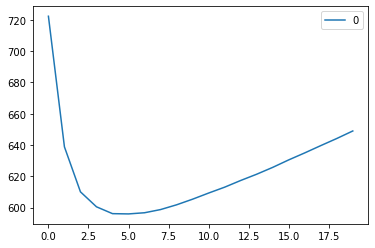

In [48]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [49]:
#For deciding the value of k, plotting the elbow curve every time is be a tedious process. we can simply use gridsearch to find the best value.

from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(X_train,y_train)
model.best_params_

{'n_neighbors': 5}

In [50]:
#checking R2 Score
from sklearn.metrics import r2_score
r2_score(y_test,pred)

0.9716410443871248